In [1]:
from functions import *
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
from pathlib import Path



In [2]:
processRaw = False #  whether to process pupil and gaze from the uncleaned file
saveFiles = False


In [3]:
#read in the mega df
local_username = 'yud070'
pathEL = "Z:/yueying/psychedeLights_YueyingDong/data/pdRaw_tracker/"
pathpy = "Z:/yueying/psychedeLights_YueyingDong/data/pdRaw_psychopy/"

readIn = sorted([f for f in os.listdir(pathpy)])[-48:-2]


relevantCols = ['RECORDING_SESSION_LABEL','AVERAGE_GAZE_X',
       'AVERAGE_GAZE_Y','AVERAGE_PUPIL_SIZE','EYE_TRACKED','IP_LABEL','IP_START_TIME',
      'LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','SAMPLE_MESSAGE','TIMESTAMP','TRIALID']
pupCols = ['EYE_TRACKED','LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','AVERAGE_PUPIL_SIZE',
           'IP_LABEL','TIMESTAMP','TRIALID']
selectEye = 'AVERAGE_PUPIL_SIZE'
included = 8000


# Load

In [4]:

# Define paths
BASE_PATH = Path("Z:/yueying/psychedeLights_YueyingDong")
PSYCHOPY_PATH = BASE_PATH / "results/data/psychopy"
PUPIL_RAW_PATH = BASE_PATH / "pupRaw_formatted"
PUPIL_CLEAN_PATH = BASE_PATH / "results/data/pupClean"

GAZE_RAW_PATH = BASE_PATH/ "gazeRaw_formatted"

# Load behavioral data
print("Loading behavioral data...")
psy_files = glob.glob(str(PSYCHOPY_PATH / "psyFull_*.csv"))
psyFull = pd.concat(
    [pd.read_csv(f) for f in psy_files],
    axis=0,
    ignore_index=True
)
print(f"  Loaded {len(psyFull)} trials from {len(psy_files)} files")

if processRaw:

    # ===== Process pupil data =====
    print("\nLoading raw pupil data for processing...")
    pupil_raw_files = glob.glob(str(PUPIL_RAW_PATH / "*.csv"))
    pupFullTrial_raw = pd.concat(
        [pd.read_csv(f).iloc[:, 1:] for f in pupil_raw_files],
        axis=0,
        ignore_index=True
    )
    print(f"  Loaded {len(pupFullTrial_raw)} trials from {len(pupil_raw_files)} files")
    
    print("\nProcessing pupil data...")
    pupClean, combined_participant_mask = process_pupil_data_pipeline(pupFullTrial_raw, psyFull,
                                           max_missing_proportion = 0.1)
    
    # ===== Process gaze data ===== 
    print("\nLoading raw gaze data for processing...")
    gaze_raw_files_x = glob.glob(str(GAZE_RAW_PATH / "*x*.csv"))
    gaze_raw_files_y = glob.glob(str(GAZE_RAW_PATH / "*y*.csv"))

    # Sanity check: make sure x and y files match
    if len(gaze_raw_files_x) != len(gaze_raw_files_y):
        print(f"  WARNING: Found {len(gaze_raw_files_x)} x-files but {len(gaze_raw_files_y)} y-files!")

    gazeFullTrial_x_raw = pd.concat(
        [pd.read_csv(f).iloc[:,1:] for f in gaze_raw_files_x],
        axis=0,
        ignore_index=True
    )
    print(f"  Loaded {len(gazeFullTrial_x_raw)} trials (x-axis) from {len(gaze_raw_files_x)} files")

    gazeFullTrial_y_raw = pd.concat(
        [pd.read_csv(f).iloc[:,1:] for f in gaze_raw_files_y],
        axis=0,
        ignore_index=True
    )
    print(f"  Loaded {len(gazeFullTrial_y_raw)} trials (y-axis) from {len(gaze_raw_files_y)} files")
    
    print("\nProcessing gaze data...")
    gaze_clean = process_gaze_data_pipeline(
        pupil_raw_df = pupFullTrial_raw,
        gaze_x_raw_df = gazeFullTrial_x_raw,
        gaze_y_raw_df = gazeFullTrial_y_raw,
        pupil_clean_df = pupClean,
        pupil_std_mask_df = combined_participant_mask,
    )

    # Extract x and y gaze data
    gaze_x = gaze_clean.loc['x']
    shift_df = calculate_gaze_shifts(gaze_clean)
    
    print(f"\n✓ Processing complete!")
    print(f"  Final pupil data: {len(pupClean)} trials")
    print(f"  Final gaze data: {len(gaze_x)} trials (x and y)")
    
else:
    print("\nLoading pre-processed pupil data...")
    pupil_clean_files = glob.glob(str(PUPIL_CLEAN_PATH / "*.csv"))
    pupClean = pd.concat(
        [pd.read_csv(f).iloc[:, 1:] for f in pupil_clean_files],
        axis=0,
        ignore_index=True
    )
    print(f"  Loaded {len(pupClean)} trials from {len(pupil_clean_files)} files")

print("\n✓ Data loading complete!")

Loading behavioral data...
  Loaded 9924 trials from 3 files

Loading pre-processed pupil data...
  Loaded 9066 trials from 3 files

✓ Data loading complete!


# Handle Psychopy data

In [5]:
# Exclude participants
rejSubj = [254, 250]
psyFull = psyFull[~psyFull['participant'].isin(rejSubj)].reset_index(drop=True)
print(f"Excluded {len(rejSubj)} participants. Remaining trials: {len(psyFull)}")

# Add cued item brightness (left or right based on cued direction)
psyFull['cuedItemBri'] = psyFull.apply(
    lambda row: row['leftBri'] if row['cuedItem'] == 'left' else row['rightBri'],
    axis=1
)

# Calculate correctness (assuming 'rsp' should equal 'cuedItem' for correct trials)
psyFull['correctness'] = np.where(psyFull.rsp !='cuedItem',0,1)

# Log-transform reaction time
psyFull['logRT'] = np.log(psyFull['rt'])

# Map distractor type based on trial type and congruency
# Logic: incongruent trials flip the modality
distractor_mapping = {
    ('congruent', 'verbal'): 'verbal',
    ('incongruent', 'verbal'): 'visual',
    ('congruent', 'visual'): 'visual',
    ('incongruent', 'visual'): 'verbal'
}

psyFull['distractorType_visVer'] = psyFull.apply(
    lambda row: distractor_mapping.get(
        (row['distractorType'], row['trlType']),
        'noDistractor'
    ),
    axis=1
)

Excluded 2 participants. Remaining trials: 9492


In [6]:
psyFull.participant.value_counts()

participant
249.0    216
284.0    216
275.0    216
276.0    216
278.0    216
279.0    216
280.0    216
281.0    216
282.0    216
283.0    216
286.0    216
251.0    216
287.0    216
289.0    216
290.0    216
291.0    216
292.0    216
293.0    216
294.0    216
295.0    216
274.0    216
273.0    216
272.0    216
271.0    216
252.0    216
253.0    216
255.0    216
256.0    216
257.0    216
258.0    216
259.0    216
260.0    216
261.0    216
262.0    216
263.0    216
264.0    216
265.0    216
266.0    216
267.0    216
268.0    216
269.0    216
270.0    216
296.0    216
288.0    204
Name: count, dtype: int64

# example trial, post cleaning

In [7]:
events = {'fixation':0,'stim':500,'precueRest':3000,'retrocue':500,'delay':500,}

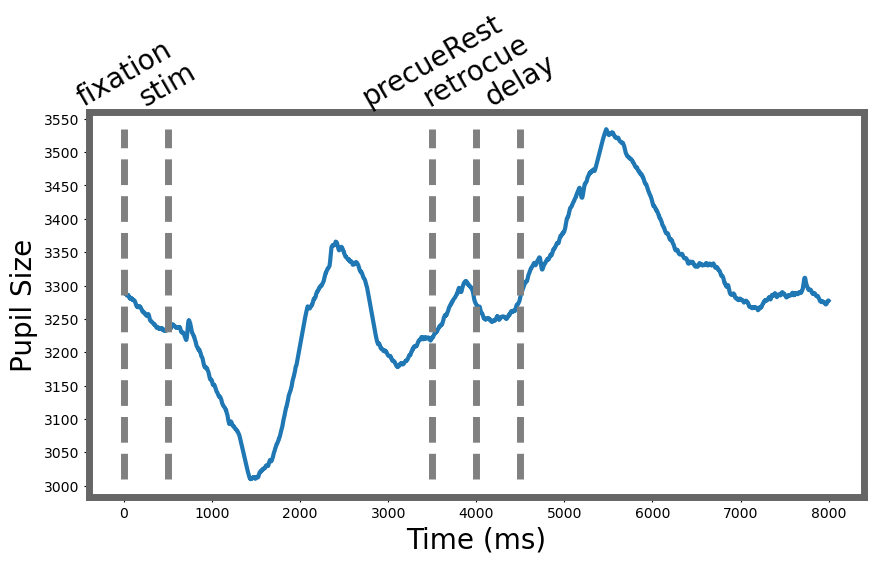

In [8]:
fs(10, 5)
fig, ax = plt.subplots()

eg = 30  # np.random.randint(pupClean.shape[0])
trial_data = pupClean.iloc[eg, 1:].values
timepoints = np.arange(len(trial_data))

# Plot pupil trace
plt.plot(timepoints, trial_data, color='#1f77b4', linewidth=3)

# Event markers
event_times = np.cumsum(list(events.values()))
y_min, y_max = np.nanmin(trial_data), np.nanmax(trial_data)
plt.vlines(event_times, y_min, y_max, 
          linestyles='dashed', colors='grey', linewidth=5)

# Optional: Add event labels
event_names = list(events.keys())
for i, (time, name) in enumerate(zip(event_times, event_names)):
    plt.text(time, y_max * 1.01, name, 
            fontsize=20, ha='center', rotation=30)

# Styling
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Pupil Size', fontsize=20)

ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))

for spine in ax.spines.values():
    spine.set_color('#666666')
    spine.set_linewidth(5)

